In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets

from stellarpunk import util

# Loading and Preparing Data

In [2]:
df_base = pd.read_json("/tmp/stellarpunk_test.test_many_threats.history.gz", lines=True)
df_base = df_base.join(pd.json_normalize(df_base["o"]).add_prefix("o."))

In [3]:
eids = pd.Series(df_base["eid"].unique())
eids

0    83f51e0e-0df8-49b2-bd03-7f3d7ad58e82
1    ced4eebb-c920-4ed5-958c-68eb695a3149
2    c4bf4df5-236b-4e64-8627-0caaadf9d357
3    82dc9fae-47cb-4021-bec2-d27ff6befffe
dtype: object

In [4]:
eids[pd.Series(df_base["eid"].unique()).str.startswith("c4c9")]

Series([], dtype: object)

In [5]:
target_eid = df_base["eid"].unique()[2]
df_base = df_base[df_base["eid"] == target_eid].reset_index()
df_base["eid"].unique()

array(['c4bf4df5-236b-4e64-8627-0caaadf9d357'], dtype=object)

In [6]:
loc = pd.DataFrame(np.vstack(df_base["loc"]), columns=["loc.x", "loc.y"])
v = pd.DataFrame(np.vstack(df_base["v"]), columns=["v.x", "v.y"])

empty_array = np.empty(len(df_base))
empty_array[:] = np.nan

if "o.t_loc" in df_base:
    o_tloc = pd.DataFrame(np.vstack(df_base["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_loc.x", "o.t_loc.y"])
    o_tv = pd.DataFrame(np.vstack(df_base["o.t_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_v.x", "o.t_v.y"])
else:
    o_tloc = pd.DataFrame({"o.t_loc": empty_array, "o.t_loc.x": empty_array, "o.t_loc.y": empty_array})
    o_tv = pd.DataFrame({"o.t_v": empty_array, "o.t_v.x": empty_array, "o.t_v.y": empty_array})
    
if "o.ct" in df_base:
    o_ctloc = pd.DataFrame(np.vstack(df_base["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_loc.x", "o.ct_loc.y"])
    o_ctdv = pd.DataFrame(np.vstack(df_base["o.ct_dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_dv.x", "o.ct_dv.y"])
else:
    o_ctloc = pd.DataFrame({"o.ct_loc": empty_array, "o.ct_loc.x": empty_array, "o.ct_loc.y": empty_array})
    o_ctdv = pd.DataFrame({"o.ct_dv": empty_array, "o.ct_dv.x": empty_array, "o.ct_dv.y": empty_array})
angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["a"])), axis=1)), columns=["angle.x", "angle.y"])
df = pd.concat([df_base, loc, v, o_ctloc, o_ctdv, o_tloc, o_tv, angle], axis=1)

if "o.ct" not in df_base:
    df["o.ct"] = empty_array
    df["o.ct_ts"] = empty_array
    df["o.cac"] = empty_array
    df["o.cbdr"] = empty_array
    df["o.ct_ct"] = empty_array
    
if "o.t_loc" not in df_base:
    df["o.cs"] = empty_array

In [7]:
df["speed"] = np.linalg.norm(df[["v.x", "v.y"]], axis=1)
df["o_ct_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_speed"] = np.linalg.norm(df[["o.t_v.x", "o.t_v.y"]], axis=1)
df["f_mag"] = df["f"].apply(lambda x:np.linalg.norm(x))

In [8]:
df["o_ct_v.x"] = (df["o.ct_loc.x"].shift(1) - df["o.ct_loc.x"]) / (df["ts"].shift(1) - df["ts"])
df["o_ct_v.y"] = (df["o.ct_loc.y"].shift(1) - df["o.ct_loc.y"]) / (df["ts"].shift(1) - df["ts"])

In [9]:
df

,index,eid,ts,loc,a,v,av,f,t,o,...,o.t_v.y,angle.x,angle.y,speed,o_ct_dist,o_t_dist,o_t_speed,f_mag,o_ct_v.x,o_ct_v.y
0,2340,c4bf4df5-236b-4e64-8627-0caaadf9d357,0.000000,"[-161273.86208171627, 11200.84407607114]",0.170811,"[-123.61634016109224, -57.03178938300922]",0.041415,"[4540.102996482443, 2094.6275996775994]",900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-22.536265,98.544727,16.998139,1.361383e+02,NaN,1602.478485,53.795398,5000.0,NaN,NaN
1,2341,c4bf4df5-236b-4e64-8627-0caaadf9d357,0.016667,"[-161275.92235405228, 11199.89354624809]",0.171501,"[-123.57850596945488, -57.01433415301191]",0.058082,"[4540.102996482438, 2094.627599677609]",900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-22.058216,98.532971,17.066156,1.360966e+02,NaN,1600.209515,52.654267,5000.0,NaN,NaN
2,2342,c4bf4df5-236b-4e64-8627-0caaadf9d357,0.033333,"[-161277.98199581844, 11198.943307345538]",0.172469,"[-123.54067177781752, -56.9968789230146]",0.074749,"[4540.102996482438, 2094.6275996776094]",900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-21.590956,98.516404,17.161531,1.360549e+02,NaN,1597.941238,51.538889,5000.0,NaN,NaN
3,2343,c4bf4df5-236b-4e64-8627-0caaadf9d357,0.050000,"[-161280.04100701475, 11197.993359363489]",0.173715,"[-123.50283758618016, -56.97942369301729]",0.091415,"[4540.102996482444, 2094.6275996775985]",900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-21.134177,98.494947,17.284251,1.360133e+02,NaN,1595.673656,50.448531,5000.0,NaN,NaN
4,2344,c4bf4df5-236b-4e64-8627-0caaadf9d357,0.066667,"[-161282.09938764118, 11197.043702301939]",0.175238,"[-123.4650033945428, -56.96196846301998]",0.108082,"[4540.102996482442, 2094.6275996776003]",900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-20.687583,98.468499,17.434297,1.359716e+02,NaN,1593.406768,49.382485,5000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,3505,c4bf4df5-236b-4e64-8627-0caaadf9d357,19.416667,"[-161370.467007451, 11156.274306648404]",0.102304,"[4.440892098500626e-16, 0.0]",-0.011741,"[0.0, 0.0]",0.0,{'o': 'stellarpunk.core.Order'},...,NaN,99.477152,10.212554,4.440892e-16,NaN,NaN,NaN,0.0,NaN,NaN
1166,3506,c4bf4df5-236b-4e64-8627-0caaadf9d357,19.433333,"[-161370.467007451, 11156.274306648404]",0.102108,"[4.440892098500626e-16, 0.0]",-0.011741,"[0.0, 0.0]",0.0,{'o': 'stellarpunk.core.Order'},...,NaN,99.479148,10.193088,4.440892e-16,NaN,NaN,NaN,0.0,NaN,NaN
1167,3507,c4bf4df5-236b-4e64-8627-0caaadf9d357,19.450000,"[-161370.467007451, 11156.274306648404]",0.101913,"[4.440892098500626e-16, 0.0]",-0.011741,"[0.0, 0.0]",0.0,{'o': 'stellarpunk.core.Order'},...,NaN,99.481141,10.173621,4.440892e-16,NaN,NaN,NaN,0.0,NaN,NaN
1168,3508,c4bf4df5-236b-4e64-8627-0caaadf9d357,19.466667,"[-161370.467007451, 11156.274306648404]",0.101717,"[4.440892098500626e-16, 0.0]",-0.011741,"[0.0, 0.0]",0.0,{'o': 'stellarpunk.core.Order'},...,NaN,99.483130,10.154153,4.440892e-16,NaN,NaN,NaN,0.0,NaN,NaN


# Basic Ship Vitals

## Position and Heading

In [10]:
def plot_location_chart(max_time):
    sample = df[df["ts"] <= max_time].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"])#, scale=100)
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"])
    #center = (0,2500)
    #radius = 10000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

ipywidgets.interact(plot_location_chart, max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=19.48333333333351, continuous_update=False, description='max_time', ma…

<function __main__.plot_location_chart(max_time)>

In [11]:
df[["loc.x", "loc.y"]].describe()

,loc.x,loc.y
count,1170.000000,1170.000000
mean,-161368.007164,11157.409183
std,11.591939,5.348072
min,-161370.467007,11156.274307
25%,-161370.467007,11156.274307
50%,-161370.467007,11156.274307
75%,-161370.467007,11156.274307
max,-161273.862082,11200.844076


Text(0.5, 1.0, 'position')

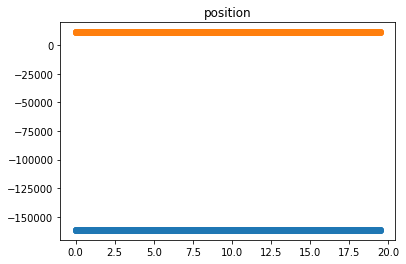

In [12]:
plt.scatter(df["ts"], df["loc.x"])
plt.scatter(df["ts"], df["loc.y"])
plt.title("position")

Text(0.5, 1.0, 'heading and angular velocity')

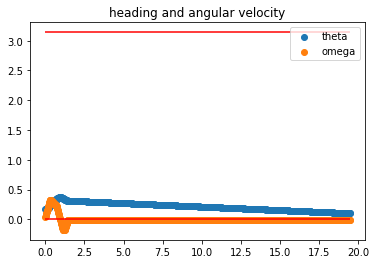

In [13]:
plt.scatter(df["ts"], df["a"], label="theta")
plt.scatter(df["ts"], df["av"], label="omega")
plt.hlines(np.pi, df["ts"].min(), df["ts"].max(), color="red")
plt.hlines(0, df["ts"].min(), df["ts"].max(), color="red")
plt.legend()
plt.title("heading and angular velocity")

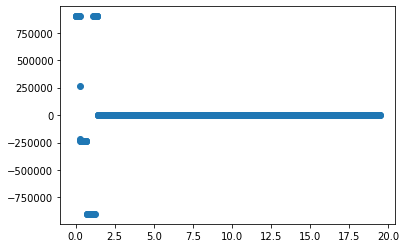

In [14]:
plt.scatter(df["ts"], df["t"])

## Velocity and Acceleration

Text(0.5, 1.0, 'velocity')

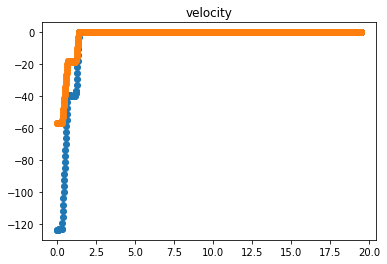

In [15]:
plt.scatter(df["ts"], df["v.x"])
plt.scatter(df["ts"], df["v.y"])
plt.title("velocity")

Text(0.5, 1.0, 'acceleration')

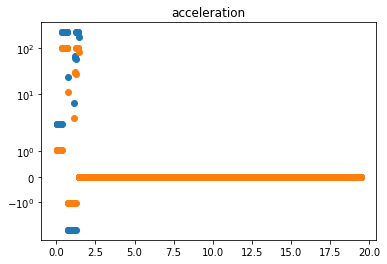

In [16]:
#plt.scatter(df["ts"], (df["v.x"] - df["v.x"].shift(-1)))#/(df["ts"]-df["ts"].shift(-1)))
plt.scatter(df["ts"], (df["v.x"].shift(1) - df["v.x"]) / (df["ts"].shift(1) - df["ts"]))
plt.scatter(df["ts"], (df["v.y"].shift(1) - df["v.y"]) / (df["ts"].shift(1) - df["ts"]))
plt.yscale("symlog")
plt.title("acceleration")

Text(0.5, 1.0, 'force')

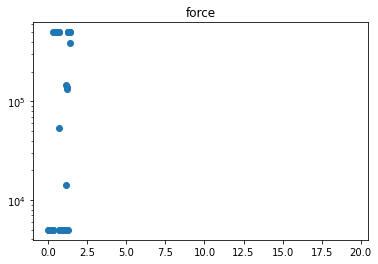

In [17]:
plt.scatter(df["ts"], df["f_mag"])
plt.yscale("log")
plt.title("force")

# Behavior Monitoring

In [18]:
def plot_collision_info(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (~(sample["o.ct"].isna())).astype(int), label="ct")
    plt.scatter(sample["ts"], sample["o.cs"].fillna(0).astype(int)+0.05, label="cs")
    plt.scatter(sample["ts"], sample["o.cac"].fillna(0).astype(int)+0.1, label="cac")
    plt.scatter(sample["ts"], sample["o.cbdr"].fillna(0).astype(int)+0.15, label="cbdr")
    plt.legend()
    plt.title("status flags")

ipywidgets.interact(plot_collision_info, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=19.483333…

<function __main__.plot_collision_info(hist_length, max_time)>

## Target Location

In [19]:
if np.any(~df["o.t_loc"].isna()):
    x = df.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"ts": ["count", "min", "max"], "o_t_dist": ["min","max"]})
else:
    x = "no location target"
x

ts              o_t_dist             
                            count  min  max         min          max
o.t_loc.x      o.t_loc.y                                            
-162728.945556 10529.524943    85  0.0  1.4  1496.14204  1602.478485

In [20]:
#sample = df[(df["ts"] < 124.4) & (df["ts"] > 120)]
def plot_target_distance(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o_t_dist"])
    plt.hlines(1500, sample["ts"].min(), sample["ts"].max(), color="green")
    plt.hlines(1500*0.9, sample["ts"].min(), sample["ts"].max(), color="red")
    #plt.ylim(0,1500)
    plt.title("distance to target")
    print(sample["o_t_dist"].min(),sample[df["ts"] > sample["ts"].max()-1]["o_t_dist"].min())

ipywidgets.interact(
    plot_target_distance,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=19.483333…

<function __main__.plot_target_distance(hist_length, max_time)>

(0.0, 142.94516806084593)

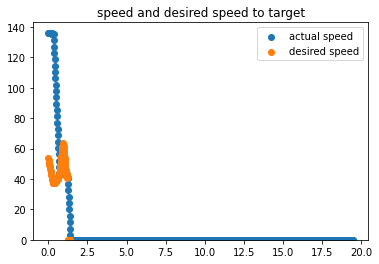

In [21]:
plt.scatter(df["ts"], df["speed"], label="actual speed")
plt.scatter(df["ts"], df["o_t_speed"], label="desired speed")
plt.legend()
plt.title("speed and desired speed to target")
plt.ylim(0)

Text(0.5, 1.0, 'desired speed delta')

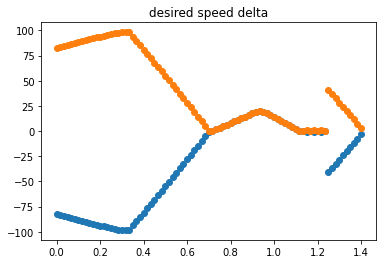

In [22]:
plt.scatter(df["ts"], df["o_t_speed"] - df["speed"])
plt.scatter(df["ts"], np.linalg.norm(np.array((df["o.t_v.x"] - df["v.x"], df["o.t_v.y"] - df["v.y"])), axis=0))
plt.title("desired speed delta")

## Collision Avoidance

In [23]:
if np.any(~df["o.ct"].isna()):
    x = df.groupby("o.ct").agg({"ts": ["count", "min", "max"], "o_ct_dist": ["min","max"]})
else:
    x = "no collision threats"
x

'no collision threats'

nan

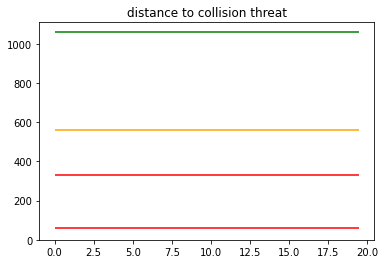

In [24]:
sample = df
plt.scatter(sample["ts"], sample["o_ct_dist"])
plt.hlines(60+500+500, sample["ts"].min(), sample["ts"].max(), color="green")
plt.hlines(60+500, sample["ts"].min(), sample["ts"].max(), color="orange")
plt.hlines(330, sample["ts"].min(), sample["ts"].max(), color="red")
plt.hlines(60, sample["ts"].min(), sample["ts"].max(), color="red")
plt.ylim(0)
plt.title("distance to collision threat")
df["o_ct_dist"].min()

Text(0.5, 1.0, 'number of coalesced threats')

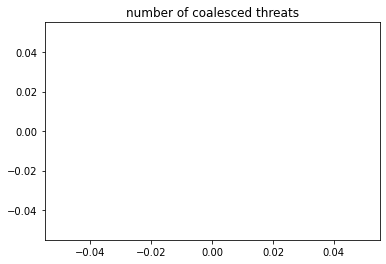

In [25]:
plt.scatter(df["ts"], df["o.ct_ct"])
plt.title("number of coalesced threats")

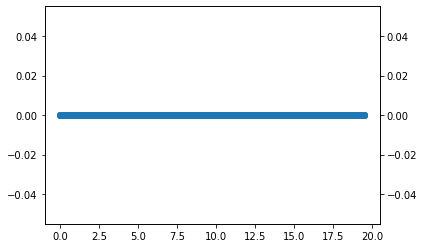

In [26]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df["ts"], 1-df["o.ct"].isna().astype(int))
ax2.scatter(df["ts"], df["ts"] - df["o.ct_ts"], color="orange")

#ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)

In [27]:
def plot_collision_dv(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_dv.x"])
    plt.scatter(sample["ts"], sample["o.ct_dv.y"])
    plt.title("collision avoidance velocity")

ipywidgets.interact(
    plot_collision_dv,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=19.483333…

<function __main__.plot_collision_dv(hist_length, max_time)>

# History Visualization

## Position and Velocity

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=19.483333…

<function __main__.plot_collision_chart(hist_length=19.48333333333351, max_time=19.48333333333351, sampling_interval=50, show_tloc=True)>

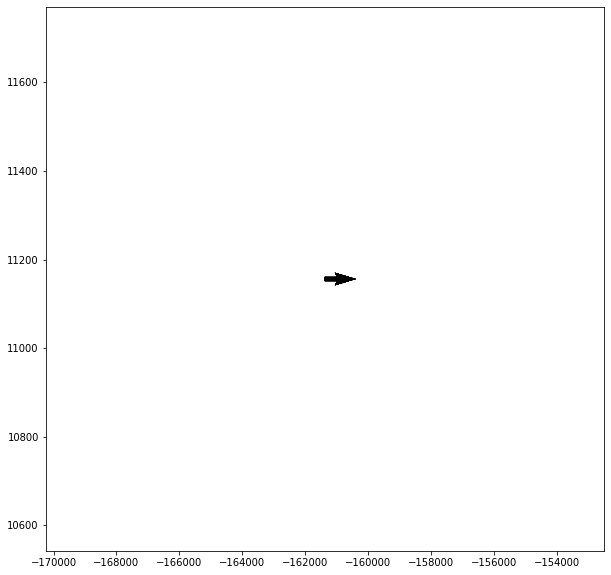

In [40]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max(), sampling_interval=50, show_tloc=True):
    plt.figure(figsize=(10, 10))
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::sampling_interval]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["v.x"], sample["v.y"], label="v")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    
    plt.quiver(sample["o.ct_loc.x"], sample["o.ct_loc.y"], sample["o_ct_v.x"], sample["o_ct_v.y"])
    cmap = plt.get_cmap('viridis')
    for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(df["o.ct"].unique())))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        if len(ct) == 0:
            continue
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    
    if show_tloc:
        plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
        for (tloc_x, tloc_y) in sample.groupby(["o.t_loc.x", "o.t_loc.y"])["o.t_loc"].min():
            arrival_dist = plt.Circle((tloc_x, tloc_y), 1500, color="green", fill=False)
            min_dist = plt.Circle((tloc_x, tloc_y), 1500*0.9, color="red", fill=False)
            plt.gca().add_patch(arrival_dist)
            plt.gca().add_patch(min_dist)
            
    t_next = 10
    x, y = sample.iloc[-1]["loc.x"], sample.iloc[-1]["loc.y"]
    x_next, y_next = sample.iloc[-1]["loc.x"]+sample.iloc[-1]["v.x"]*t_next, sample.iloc[-1]["loc.y"]+sample.iloc[-1]["v.y"]*t_next
    if x_next != x or y_next != y:
        plt.axline((x,y),(x_next,y_next),marker = 'o')
    
    plt.axis('equal')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.show()
    
ipywidgets.interact(
    plot_collision_chart,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(step=1/60, value=df["ts"].max()+1/60, min=df["ts"].min(), max=df["ts"].max()+1/60, continuous_update=False),
    sampling_interval=ipywidgets.IntSlider(value=20, min=1, max=100, continuous_update=False),
    show_tloc=ipywidgets.Checkbox(value=True),
)

## Position and Heading

In [29]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]#.iloc[::10]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"], label="ship")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    #for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(sample["o.ct"].unique())))):
    #    print(x)
    #    if not isinstance(x, str):
    #        continue
    #    ct = sample[sample["o.ct"] == x]
    #    plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    #plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    #plt.axis('square')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)
    
    plt.legend()
    plt.axis('equal')
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=19.483333…

<function __main__.plot_collision_chart(hist_length=19.48333333333351, max_time=19.48333333333351)>

# 